In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. feladat

Adott $g$ ablakfüggvény mellett $f$ jel Gábor-transzformáltja 
$$S_f(\omega^\prime, \tau)=\int\,f(t) g^*(t-\tau) e^{-j\omega^\prime t}\,\mathrm{d}t.$$

Lásd be, ha létezik az inverz, akkor annak alakja:
$$f(t) = \frac{1}{2\pi}\int\int\, S_f(\omega^\prime, \tau) g(t-\tau) e^{j\omega^\prime t}\,\mathrm{d}\omega^\prime\mathrm{d}\tau.$$


### Megoldás

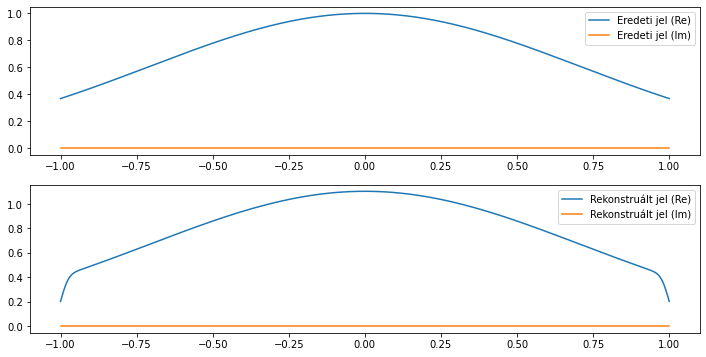

In [2]:
# f(t)
def jel(t):
    return np.exp(-t**2)

#  g(t) Guass ablak
def ablak(t, tau, omega_prime):
    sigma = 0.015
    return np.exp(-((t - tau)**2) / (2 * sigma**2)) * np.exp(1j * omega_prime * t) 

# paraméterek
N = 1000 # minták száma
T = 2.0  # jelhossz
dt = T / N  # időlépés

# x tengely 
t = np.linspace(-T/2, T/2, N)

# Gábor traszformácó
omega_prime_values = np.linspace(-10, 10, 100) #omega'-t itt futtatjuk végig
tau_values = np.linspace(-1, 1, 100) # tau értékeket pedig itt
S_f = np.zeros((len(omega_prime_values), len(tau_values)), dtype=complex)

for i, omega_prime in enumerate(omega_prime_values):
    for j, tau in enumerate(tau_values): #e^ tagot már korábban az ablak függvényben definiáltam
        S_f[i, j] = np.trapz(jel(t) * np.conj(ablak(t, tau, omega_prime)), t) #np.trapz segítségével végzem az integrálás


reconstructed = np.zeros(N, dtype=complex)
#elvégeztem a inverz traszformációt is 
for i, omega_prime in enumerate(omega_prime_values):
    for j, tau in enumerate(tau_values):
        reconstructed += S_f[i, j] * ablak(t, tau, omega_prime)

reconstructed /= (2 * np.pi) 

figure(figsize=(12, 6))
subplot(2, 1, 1)
plot(t, np.real(jel(t)), label='Eredeti jel (Re)')
plot(t, np.imag(jel(t)), label='Eredeti jel (Im)')
legend()

subplot(2, 1, 2)
plot(t, np.real(reconstructed), label='Rekonstruált jel (Re)')
plot(t, np.imag(reconstructed), label='Rekonstruált jel (Im)')
legend()



Egész jó pontossággal sikerült vissza állítani az eredeti jelet, tehát a képlet tényleg ilyen alakot vesz fel.

# 2. feladat

A Gábor-transzformációban választott $g$ ablak függvény szélességét, illetve frekvenciafelbontó képességét annak Fourier-transzformáltjának ($G$) segítségével eképp definiáljuk:

* $\Delta t^2 = \frac{\int\,t^2|g(t)|^2\,\mathrm{d}t}{\int\,|g(t)|^2\,\mathrm{d}t}$
* $\Delta \omega^2 = \frac{\int\,\omega^2|G(\omega)|^2\,\mathrm{d}\omega}{\int\,|G(\omega)|^2\,\mathrm{d}\omega}$

A jelfeldolgozásbeli határozatlansági reláció szerint ezek szorzata alulról korlátosak, $\Delta t\Delta\omega\geq\frac{1}{2}$.

Számoljuk kiezt a _bandwidth-delay_ szorzatot több ablakfüggvényre is:
* Gauss-ablak
* boxcar-ablak
* Hanning-ablak
* Hamming-ablak
* Barlet-ablak.

Vizsgáljuk meg ezeket a mennyiségeket numerikusan is.

### Megoldás:

In [3]:
from scipy.integrate import quad

### Gauss-ablak

A Gauss ablakfüggvényünk: $$g(t) = e^{-\alpha \cdot t}$$

Ennek a Fourier-transzformáltja: $$G(\omega) = \frac{1}{\sqrt{2\alpha}} e^{-\frac{\omega^2}{4\alpha}}$$

A megoldáshoz $\alpha$ értékét most 1-nek vettem.

In [4]:
def gaussian_window(alpha, t):
    return np.exp(-alpha * t**2)

def gaussian_fourier_transform(alpha, omega):
    return 1 / np.sqrt(2 * alpha) * np.exp(-omega**2 / (4 * alpha))


In [5]:
#lambda fügvényekkel definiáltam az integrálandó függvényeket
szamlalo_ablak = lambda t: t**2 * np.abs(gaussian_window(1, t))**2
nevezo_ablak = lambda t: np.abs(gaussian_window(1, t))**2

# integrálok meghatározása
szamlalo, _ = quad(szamlalo_ablak, -np.inf, np.inf)
nevezo, _ = quad(nevezo_ablak, -np.inf, np.inf)

# tört meghatározása
delta_t_2 = szamlalo / nevezo

szamlalo_trafo = lambda omega: omega**2 * np.abs(gaussian_fourier_transform(1, omega))**2
nevezo_trafo = lambda omega: np.abs(gaussian_fourier_transform(1, omega))**2

szamlalo_eredmeny, _ = quad(szamlalo_trafo, -np.inf, np.inf)
nevezo_eredmeny, _ = quad(nevezo_trafo, -np.inf, np.inf)

# omega^2
delta_omega_2 = szamlalo_eredmeny / nevezo_eredmeny

delta_t = np.sqrt(delta_t_2)
delta_omega = np.sqrt(delta_omega_2)

#szorzat
bandwidth_delay = delta_t * delta_omega

print("Delta t * Delta omega:", round(bandwidth_delay,1))
print("A gauss ablak bandwidth-delay értéke pontosan: 0.5")

Delta t * Delta omega: 0.5
A gauss ablak bandwidth-delay értéke pontosan: 0.5


### Boxcar-ablak

In [6]:
def boxcar_window(t, T):
    y = []
    if t >= 0 and t <= 0+T:
        y.append(1)
    else: 
        y.append(0)
    y = np.array(y)
    return y

def boxcar_fourrier_transform(omega):
    return np.sinc(omega)


#ugyan azokat a lépéseket követtem
szamlalo_ablak = lambda t: t**2 * np.abs(boxcar_window(t ,2))**2
nevezo_ablak = lambda t: np.abs(boxcar_window(t, 2))**2


szamlalo, _ = quad(szamlalo_ablak, -5, 5)
nevezo, _ = quad(nevezo_ablak, -5, 5)
delta_t_2 = szamlalo / nevezo


szamlalo_trafo = lambda omega: omega**2 * np.abs(boxcar_fourrier_transform(omega))**2
nevezo_trafo = lambda omega: np.abs(boxcar_fourrier_transform(omega))**2


szamlalo_eredmeny, _ = quad(szamlalo_trafo, -5, 5) #le kellett venni végtelenről, mert a sinc inegrálási hibába ütközött
nevezo_eredmeny, _ = quad(nevezo_trafo, -5, 5)
delta_omega_2 = szamlalo_eredmeny / nevezo_eredmeny


delta_t = np.sqrt(delta_t_2)
delta_omega = np.sqrt(delta_omega_2)


bandwidth_delay = delta_t * delta_omega

print("Delta t * Delta omega:", round(bandwidth_delay, 1))
print("A boxcarra is teljesült")


Delta t * Delta omega: 0.8
A boxcarra is teljesült


### Hanning ablak

In [7]:


def hanning_window(x, L):
    return np.where(np.abs(x) <= L/2, 1/L * np.cos(np.pi * x / L)**2, 0)

def hanning_window_fourier(omega, L):
    return 0.5 * np.sinc(L * omega / (2 * np.pi))

szamlalo_hanning = lambda t: t**2 * np.abs(hanning_window(t, 1))**2
nevezo_hanning = lambda t: np.abs(hanning_window(t, 1))**2

szamlalo_hanning_result, _ = quad(szamlalo_hanning, -np.inf, np.inf)
nevezo_hanning_result, _ = quad(nevezo_hanning, -np.inf, np.inf)
delta_t_2_hanning = szamlalo_hanning_result / nevezo_hanning_result

szamlalo_trafo_hanning = lambda omega: omega**2 * np.abs(hanning_window_fourier(omega, 1))**2
nevezo_trafo_hanning = lambda omega: np.abs(hanning_window_fourier(omega, 1))**2

szamlalo_eredmeny_hanning, _ = quad(szamlalo_trafo_hanning, -241,241)
nevezo_eredmeny_hanning, _ = quad(nevezo_trafo_hanning, -241, 241) # addig mentem amíg nem adott hibát
delta_omega_2_hanning = szamlalo_eredmeny_hanning / nevezo_eredmeny_hanning

delta_t_hanning = np.sqrt(delta_t_2_hanning)
delta_omega_hanning = np.sqrt(delta_omega_2_hanning)

bandwidth_delay_hanning = delta_t_hanning * delta_omega_hanning

print("Delta t * Delta omega for Hanning window:", round(bandwidth_delay_hanning, 2))


Delta t * Delta omega for Hanning window: 1.75


Tapasztalataim szerint eddig ez adja a legmagasabb értéket.

### Hamming window

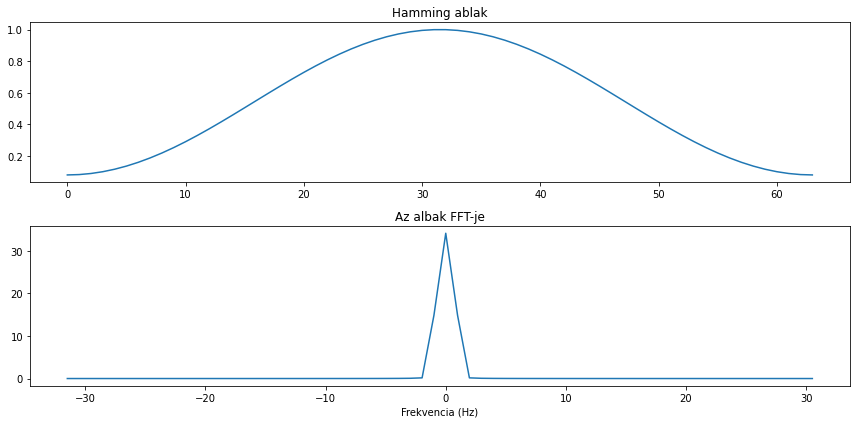

In [8]:
def hamming_window(N):
    n = np.arange(0, N)
    return 0.54 - 0.46 * np.cos(2 * np.pi * n / (N - 1))

N = 64
hamming_values = hamming_window(N)
fft_values = np.fft.fft(hamming_values)
frequencies = np.fft.fftfreq(N, 1/(N-1))

figure(figsize=(12, 6))

subplot(2, 1, 1)
plot(np.arange(N), hamming_values)
title('Hamming ablak')

subplot(2, 1, 2)
plot(np.fft.fftshift(frequencies), np.fft.fftshift(np.abs(fft_values)))
title('Az albak FFT-je')
xlabel('Frekvencia (Hz)')

tight_layout()



In [9]:
frek = np.fft.fftshift(frequencies)
amp = np.fft.fftshift(np.abs(fft_values))

In [10]:
N = np.arange(N)

In [11]:
values = []
szamlalo1 = []
nevezo1 = []
szamlalo2 = []
nevezo2 = []

for index in range(len(hamming_values)):
    szamlalo1.append(N[index]**2*abs(hamming_values[index])**2)
    nevezo1.append(abs(hamming_values[index])**2)
    
for index in range(len(frek)):
    szamlalo2.append(frek[index]**2*abs(amp[index])**2)
    nevezo2.append(abs(amp[index])**2)

    
dt = sqrt(sum(array(szamlalo1))/sum(array(nevezo1))) #sima tagok
domega = sqrt(sum(array(szamlalo2))/sum(array(nevezo2)))


print(dt*domega) #ezt csak manuálisan tudtam meghatározni, elvileg az eredmény

16.995585820336654


### Barlet - window

In [12]:
def Bartlett(t, N): #Barlett ablak
    val = 0 
    if 0 < t < N / 2:
        val = 2 * t / N
    elif N / 2 < t < N:
        val = 2 - 2*t / N
    return val


In [13]:
tprob = linspace(-10,20,1000)
ipsz = []
N = 10
for time in tprob:
    ipsz.append(Bartlett(time,N))
    

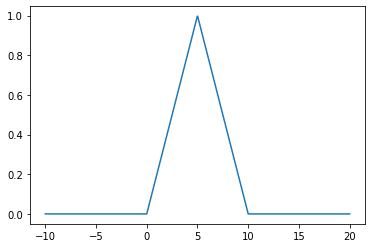

In [14]:
plot(tprob,ipsz)

In [15]:
#Ezt is csak így tudtam
N = len(ipsz)
N_freq = len(frek)


fft_values = np.fft.fft(ipsz)
frequencies = np.fft.fftfreq(N, 1/(N-1))
N_values = np.arange(N)

values = []
szamlalo1 = []
nevezo1 = []
szamlalo2 = []
nevezo2 = []


for index in range(N):
    szamlalo1.append(N_values[index]**2 * abs(ipsz[index])**2)
    nevezo1.append(abs(ipsz[index])**2)


for index in range(N_freq):
    szamlalo2.append(frek[index]**2 * abs(fft_values[index])**2)
    nevezo2.append(abs(fft_values[index])**2)


dt = np.sqrt(np.sum(np.array(szamlalo1)) / np.sum(np.array(nevezo1)))
domega = np.sqrt(np.sum(np.array(szamlalo2)) / np.sum(np.array(nevezo2)))

print(dt * domega)


15347.300109769885


# 3. feladat

Az órán felvázoltuk a diszkrét Gábor-transzformációnál a szabályos $(\tau_0, \omega_0)$ rács feltételeit. Hozz példát és keress ellenpéldát!

# 4. feladat

A Wigner-eloszlásfüggvény konstrukciója folytonos $f$ jelre:
$$W_f(\tau, \omega) = \int\,f\left(\tau+\frac{t}{2}\right)f^*\left(\tau-\frac{t}{2}\right)e^{j\omega t}\,\mathrm{d}t.$$

Lásd be, hogy teljesül $f$ Fourier-transzformáltjára ($F$-re), hogy
$$W_f(\tau, \omega) = \frac{1}{2\pi}\int\,F\left(\omega+\frac{\xi}{2}\right)F^*\left(\omega-\frac{\xi}{2}\right)e^{j\tau \xi}\,\mathrm{d}\xi.$$

* Számold ki a Wigner-eloszlásfüggvény marginálisainak kifejezését, és állapítsd meg jelentésüket
    * $\int\,W_f(\tau, \omega)\,\mathrm{d}\tau$
    * $\int\,W_f(\tau, \omega)\,\mathrm{d}\omega$
* Határozd meg az inverz transzformáció képletét.

# 5. feladat

A folytonos Haar-wavelet szülőosztálya:
$$H(t)=\left\{\begin{array}{l}0,\quad\mathrm{ha}\,\,|t|>\frac{1}{2}\\-1,\quad\mathrm{ha}\,\,t\in\left[-\frac{1}{2},0\right)\\1,\quad\mathrm{ha}\,\,t\in\left[0,\frac{1}{2}\right]\end{array}\right..$$

Mi a hozzá társítható skálafüggvény?

Számold ki a skálatörvényben az együtthatókat, ha a bázisfüggvényeket felére zsugorítjuk.

Mi a Haar-wavelet diszkrét sorozatokon? Végy egy 1D diszkrét jelsorozatot. Fejtsd ki a Haar-wavletben, és ábrázold az együtthatókat. Mennyire torzul a jelalak, ha a legkisebb abszolút értékú együtthatók $\alpha$ hányadát eldobjuk. Számszerűsítsd a hibát $\alpha$ függvényében.

### Megoldás

A hozzátartozó skálázási függvény:
$$\varphi (t)  = \left\{\begin{array}{l}1,\quad\mathrm{ha}\,\,0\leq t < 1\\0 \quad\mathrm{különben}\end{array}\right..$$

# 6. feladat

A `/v/courses/adattudomany.public/wavelet/` könyvtárában található hangfájlok a fizika 1 alaplabor ultrahang szonár mérőeszközével lettek rögzítve. 

Válassz alkalmas wavelet bázist és az egyik jelsorozatot fejtsd ki segítségével. Készítsd el a wavelet együtthatók statisztikáját, illetve ábrázold is az együtthatókat.

A legnagyobb wavelet együtthatók megtartásával szűrd a jelet. Vizsgáld meg a _soft_ és a _hard_ küszöbölésnek milyen hatása van a szűrt jelre. Diszkutáld a tapasztalataid.

# 7. feladat

Szerkessz linearis felfutású chirp jelet és keverj hozzá zajt. Ezzel szimuláljuk egy radarberendezéssel rögzített jelet.

Keresd meg a jelet illesztett szűrő segítségével és próbáld szűrni a jelet waveletek segítségével.

Összegezd a tapasztalataid. 

Tekinthetünk a szűrésre úgy is, mint veszteséges tömörítés. Próbáld számszerűsíteni a tömörítés illetve a veszteség mértékét.

Text(0.5, 1.0, 'Lineáris felfutású chirp jel')

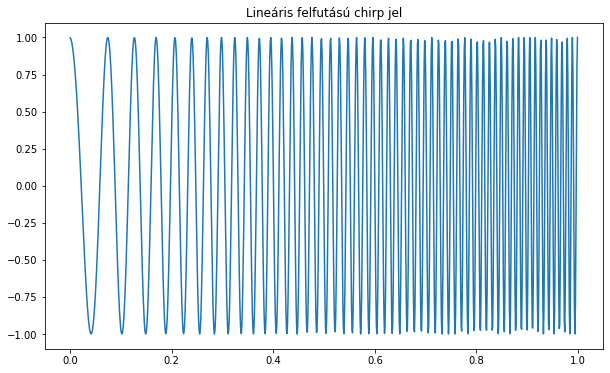

In [16]:
# Paraméterek
fs = 1000  #mintavételezési frekvencia (Hz)
T = 1  #jel hossza
t = np.arange(0, T, 1/fs)  #idő

# Lineáris felfutású chirp jel létrehozása
f_start = 10  # kezdőfrekv. (Hz)
f_end = 100  # végfrekv.(Hz)
chirp_signal = np.cos(2 * np.pi * np.cumsum(np.linspace(f_start, f_end, len(t))/fs)) #a np.cumsum segytségével növeltem a frekvenciát folyamatosan



# Jel és zaj megjelenítése
figure(figsize=(10, 6))
plot(t, chirp_signal)
title('Lineáris felfutású chirp jel')



In [17]:
# zaj amplitúdója
noise_amp = 0.1 * chirp_signal.max()

# zaj jel létrehozása
noise = np.random.randn(len(chirp_signal)) * noise_amp

noisy_chirp_signal = chirp_signal + noise


Text(0.5, 1.0, 'Zajos Chirp')

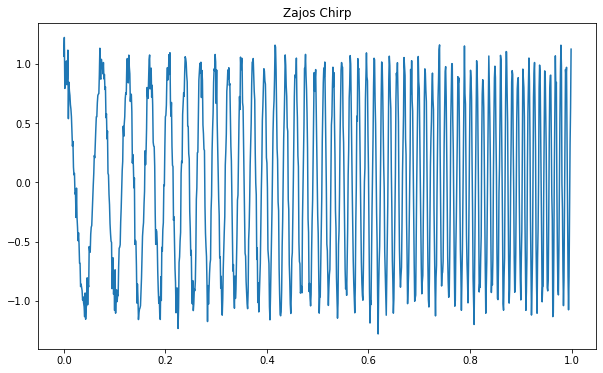

In [18]:
figure(figsize=(10, 6))
plot(t, noisy_chirp_signal)
title("Zajos Chirp")

Text(0.5, 1.0, 'Zajos jel és szűrt jel')

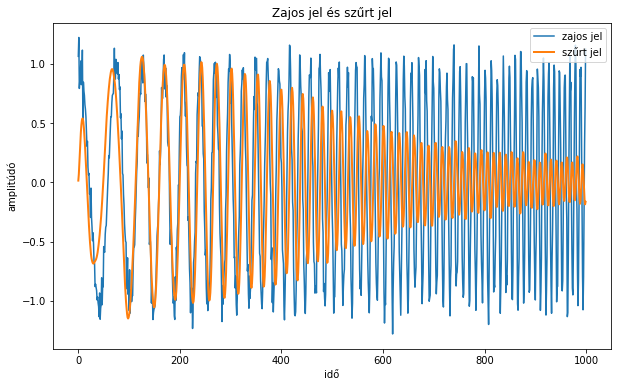

In [19]:
from scipy.signal import butter, sosfilt
# sáváteresztő szűrő paraméterei
lowcut = 10  # alsó vágás
highcut = 50  # felső vágás
fs = 1000  


sos = butter(N=2, Wn=[lowcut, highcut], btype='band', fs=fs, output='sos')

filtered_signal = sosfilt(sos, noisy_chirp_signal)

figure(figsize=(10, 6))
plot(noisy_chirp_signal, label='zajos jel')
plot(filtered_signal, label='szűrt jel', linewidth=2)
legend()
xlabel('idő')
ylabel('amplitúdó')
title('Zajos jel és szűrt jel')

Az amplitudó csökkenés nem tudom miért tapasztalható, viszont a frekvencia folyamatos növekedése, jól kivehető.

# 8. feladat

Wavelet transzformálj 2D diszkrét jelet, így egy képfájlt. Próbáld megkeresni, melyek azok az együtthatók, amik az eredeti jel egy előre kiválasztott részét reprezentálják.

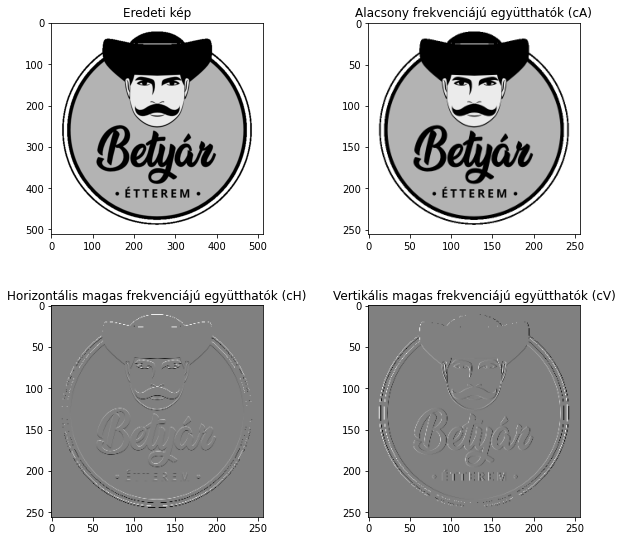

In [20]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image


image = np.array(Image.open("betyár.png").convert("L"))

#2D diszkrét wavelet transzformáció
coeffs = pywt.dwt2(image, 'db1') #Daubechies wawlet használatát ajálották az interneten

#együtthatók
cA, (cH, cV, cD) = coeffs

figure(figsize=(8, 8))

subplot(2, 2, 1)
imshow(image, cmap='gray')
title('Eredeti kép')


subplot(2, 2, 2)
imshow(cA, cmap='gray')
title('Alacsony frekvenciájú együtthatók (cA)')

subplot(2, 2, 3)
imshow(cH, cmap='gray')
title('Horizontális magas frekvenciájú együtthatók (cH)')

subplot(2, 2, 4)
imshow(cV, cmap='gray')
title('Vertikális magas frekvenciájú együtthatók (cV)')

tight_layout()
subplots_adjust(wspace=0.5)



In [21]:
roi_start_row, roi_end_row = 125, 250
roi_start_col, roi_end_col = 175, 335
roi = image[roi_start_row:roi_end_row, roi_start_col:roi_end_col]


Text(0.5, 1.0, 'Kiválasztott Rész')

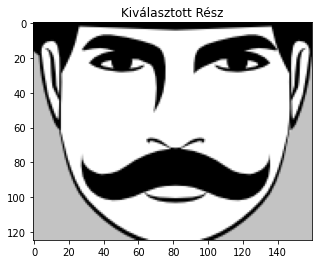

In [22]:
plt.imshow(roi, cmap='gray')
plt.title('Kiválasztott Rész')

In [23]:
roi_coeffs = pywt.dwt2(roi, 'db1')
roi_cA, (roi_cH, roi_cV, roi_cD) = roi_coeffs

Text(0.5, 1.0, 'Alacsony frekvenciájú együtthatók (cA) a kiválasztott régióban')

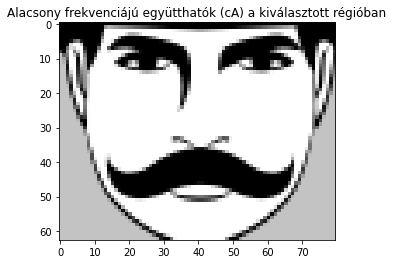

In [24]:

imshow(roi_cA, cmap='gray')
title('Alacsony frekvenciájú együtthatók (cA) a kiválasztott régióban')




Az alacsony frekvenciájú együtthatók reprezentáják a legnagyobb mértékben az eredeti képet.